In [1]:
import os
import random
import numpy as np
import tensorflow as tf
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow_text as tf_text
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LeakyReLU, Dropout

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [4]:
def build_model():
    # defining the model
    model = Sequential()
    # input layer
    model.add(Input(shape= (128, 768), name= 'embedding'))
    # CNN-1
    model.add(Conv1D(128, 3, activation = LeakyReLU(alpha = 0.2)))
    # Pooling layer-1
    model.add(MaxPooling1D())
    # CNN-2
    model.add(Conv1D(64, 3, activation = 'relu'))
    # Pooling layer-2
    model.add(GlobalMaxPooling1D())
    # Dense layer
    model.add(Dense(32, activation = 'tanh'))
    #dropout layer
    model.add(Dropout(0.3))
    #output layer
    model.add(Dense(6, activation ='softmax'))
    return model

In [5]:
def get_embedding(questions):
    
    text_input = tf.keras.layers.Input(shape=(), dtype = tf.string)
    preprocess_path = "D:/roberta/roberta_en_cased_preprocess_1"
    path = "D:/roberta/base"
    preprocess_model = hub.KerasLayer(preprocess_path)    
    encoder = hub.KerasLayer(path)
    
    encoder_inputs = preprocess_model(text_input)
    outputs = encoder(encoder_inputs)["sequence_output"] 

    embedding_model = tf.keras.Model(text_input, outputs)
    embeddings = embedding_model(tf.constant(questions))
    return embeddings

In [6]:
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    predicted_classes = np.argmax(pred, axis = 1)
    true_classes = np.argmax(y_test, axis = 1)
    
    np.save('visualization/predicted_classes.npy', predicted_classes)
    np.save('visualization/true_classes.npy', true_classes)
    
    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f"Accuracy: {accuracy}")
    f1 = f1_score(true_classes, predicted_classes, average = 'weighted')
    print(f"F1 score: {f1}")
    print(classification_report(true_classes, predicted_classes))

In [7]:
def plot_result(log_data): 
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['loss'], label ='train')
    plt.plot(log_data['val_loss'], label ='test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['accuracy'], label ='train')
    plt.plot(log_data['val_accuracy'], label ='test')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['f1_score'], label ='train')
    plt.plot(log_data['val_f1_score'], label ='test')
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [8]:
questions = pd.read_csv('data/combined_dataset.csv')
questions

,QUESTION,BT LEVEL
0,"Suppose prices of two goods are constant, expl...",Comprehension
1,Explain the concept of price leadership observ...,Comprehension
2,Define profit. Briefly explain how accounting ...,Comprehension
3,Describe the assumptions of monopolistic compe...,Comprehension
4,Explain the meaning of the law of diminishing ...,Comprehension
...,...,...
2517,PEST and SWOT are popular strategy tools. Disc...,Application
2518,List the advantages and disadvantages of Publi...,Knowledge
2519,Show your calculations for all THREE (3) optio...,Analysis
2520,Currently the product life cycle for Apple iPo...,Evaluation


In [9]:
X = questions['QUESTION']
cognitive_level = {"Knowledge": 0, "Comprehension": 1, "Application": 2, "Analysis": 3, "Synthesis": 4, "Evaluation": 5}
questions["BT LEVEL"].replace(cognitive_level, inplace = True)
y = questions['BT LEVEL'].values

In [10]:
X_train, X_test, y_train, y_test  = train_test_split(X, y , test_size = 0.10, stratify = questions['BT LEVEL'], 
                                                                             shuffle = True, random_state = 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
X_train_roberta_base = get_embedding(X_train)
X_test_roberta_base = get_embedding(X_test)

In [12]:
np.save('embedding/embeddings-train.npy', X_train_roberta_base)
np.save('embedding/embeddings-test.npy', X_test_roberta_base)

In [13]:
X_train_roberta_base = np.load('embedding/embeddings-train.npy')
X_test_roberta_base = np.load('embedding/embeddings-test.npy')

In [14]:
#model
model = build_model()
# compiling the model
optimizer = tf.keras.optimizers.RMSprop()
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics= ['accuracy', tfa.metrics.F1Score(6, 'weighted')])
# printing summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 128)          295040    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 64)            24640     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0

In [15]:
training_logger = CSVLogger('log/Roberta/training.log', separator = ',', append = False)
mcp_save = ModelCheckpoint('saved_models/Roberta/EQCM.h5', save_best_only = True, monitor ='val_accuracy', mode= 'max')

In [16]:
# fit the model
model.fit(X_train_roberta_base, y_train, epochs = 100, batch_size = 8, validation_data = (X_test_roberta_base, y_test),
                                                  callbacks = [training_logger, mcp_save], verbose = 1)

Epoch 1/100
284/284 [==============================] - 9s 25ms/step - loss: 1.3604 - accuracy: 0.4795 - f1_score: 0.4587 - val_loss: 0.9500 - val_accuracy: 0.6798 - val_f1_score: 0.6647
Epoch 2/100
284/284 [==============================] - 7s 24ms/step - loss: 0.7545 - accuracy: 0.7312 - f1_score: 0.7290 - val_loss: 0.7599 - val_accuracy: 0.7312 - val_f1_score: 0.7325
Epoch 3/100
284/284 [==============================] - 7s 25ms/step - loss: 0.4946 - accuracy: 0.8418 - f1_score: 0.8410 - val_loss: 0.6970 - val_accuracy: 0.8024 - val_f1_score: 0.8011
Epoch 4/100
284/284 [==============================] - 7s 26ms/step - loss: 0.3083 - accuracy: 0.9017 - f1_score: 0.9014 - val_loss: 0.9209 - val_accuracy: 0.7154 - val_f1_score: 0.7219
Epoch 5/100
284/284 [==============================] - 7s 26ms/step - loss: 0.2146 - accuracy: 0.9343 - f1_score: 0.9343 - val_loss: 0.7766 - val_accuracy: 0.7787 - val_f1_score: 0.7799
Epoch 6/100
284/284 [==============================] - 8s 28ms/step - 

Epoch 45/100
284/284 [==============================] - 7s 24ms/step - loss: 0.0194 - accuracy: 0.9969 - f1_score: 0.9969 - val_loss: 1.8779 - val_accuracy: 0.8142 - val_f1_score: 0.8121
Epoch 46/100
284/284 [==============================] - 7s 25ms/step - loss: 0.0202 - accuracy: 0.9969 - f1_score: 0.9969 - val_loss: 1.9673 - val_accuracy: 0.8300 - val_f1_score: 0.8277
Epoch 47/100
284/284 [==============================] - 8s 27ms/step - loss: 0.0079 - accuracy: 0.9974 - f1_score: 0.9974 - val_loss: 2.0294 - val_accuracy: 0.8063 - val_f1_score: 0.8078
Epoch 48/100
284/284 [==============================] - 7s 25ms/step - loss: 4.5189e-04 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 1.6811 - val_accuracy: 0.8300 - val_f1_score: 0.8290
Epoch 49/100
284/284 [==============================] - 7s 26ms/step - loss: 0.0048 - accuracy: 0.9991 - f1_score: 0.9991 - val_loss: 2.0604 - val_accuracy: 0.8024 - val_f1_score: 0.8007
Epoch 50/100
284/284 [==============================] - 8s 27

Epoch 89/100
284/284 [==============================] - 7s 24ms/step - loss: 0.0026 - accuracy: 0.9987 - f1_score: 0.9987 - val_loss: 2.5149 - val_accuracy: 0.8300 - val_f1_score: 0.8284
Epoch 90/100
284/284 [==============================] - 7s 24ms/step - loss: 0.0019 - accuracy: 0.9996 - f1_score: 0.9996 - val_loss: 2.5500 - val_accuracy: 0.7945 - val_f1_score: 0.7927
Epoch 91/100
284/284 [==============================] - 7s 24ms/step - loss: 0.0037 - accuracy: 0.9996 - f1_score: 0.9996 - val_loss: 2.8906 - val_accuracy: 0.7945 - val_f1_score: 0.7933
Epoch 92/100
284/284 [==============================] - 7s 24ms/step - loss: 1.2121e-04 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 2.7272 - val_accuracy: 0.8182 - val_f1_score: 0.8168
Epoch 93/100
284/284 [==============================] - 7s 24ms/step - loss: 1.1996e-05 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 2.8396 - val_accuracy: 0.8182 - val_f1_score: 0.8175
Epoch 94/100
284/284 [==============================] - 7

In [17]:
log_data = pd.read_csv('log/Roberta/training.log', sep = ',', engine = 'python')
log_data.head(50)

,epoch,accuracy,f1_score,loss,val_accuracy,val_f1_score,val_loss
0,0,0.479506,0.458695,1.360431,0.679842,0.664705,0.950010
1,1,0.731159,0.729044,0.754483,0.731225,0.732496,0.759905
2,2,0.841781,0.841014,0.494599,0.802372,0.801126,0.696965
3,3,0.901719,0.901436,0.308293,0.715415,0.721943,0.920896
4,4,0.934332,0.934304,0.214646,0.778656,0.779865,0.776632
5,5,0.953283,0.953274,0.143372,0.798419,0.793795,0.775760
6,6,0.971353,0.971343,0.086600,0.818182,0.817017,0.759111
7,7,0.980167,0.980162,0.060161,0.766798,0.769854,1.010846
8,8,0.985456,0.985462,0.043190,0.786561,0.772399,1.002501
9,9,0.991186,0.991178,0.029110,0.810277,0.811003,0.855964


In [18]:
log_data['val_accuracy'].describe()

count    100.000000
mean       0.807866
std        0.026272
min        0.679842
25%        0.794466
50%        0.810277
75%        0.826087
max        0.861660
Name: val_accuracy, dtype: float64

In [19]:
log_data['val_f1_score'].describe()

count    100.000000
mean       0.806863
std        0.026904
min        0.664705
25%        0.795586
50%        0.811057
75%        0.824761
max        0.860893
Name: val_f1_score, dtype: float64

In [20]:
model.load_weights("saved_models/Roberta/EQCM.h5")
evaluate_model(model, X_test_roberta_base, y_test)

8/8 [==============================] - 0s 27ms/step
Accuracy: 0.8616600790513834
F1 score: 0.8608927150950151
              precision    recall  f1-score   support

           0       0.91      0.86      0.88        35
           1       0.89      0.93      0.91        96
           2       0.85      0.72      0.78        32
           3       0.90      0.87      0.88        30
           4       0.72      0.93      0.81        28
           5       0.86      0.75      0.80        32

    accuracy                           0.86       253
   macro avg       0.85      0.84      0.84       253
weighted avg       0.87      0.86      0.86       253



In [21]:
log_data[['val_accuracy']].idxmax() + 1

val_accuracy    72
dtype: int64

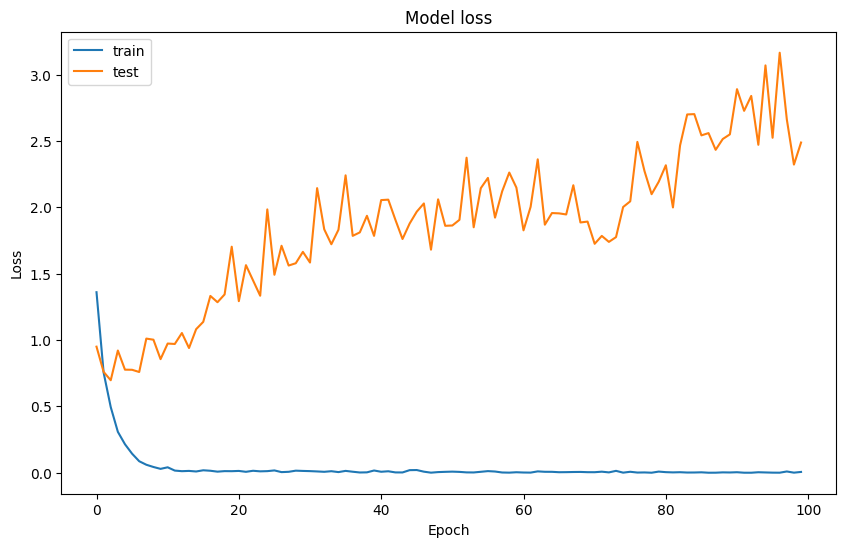

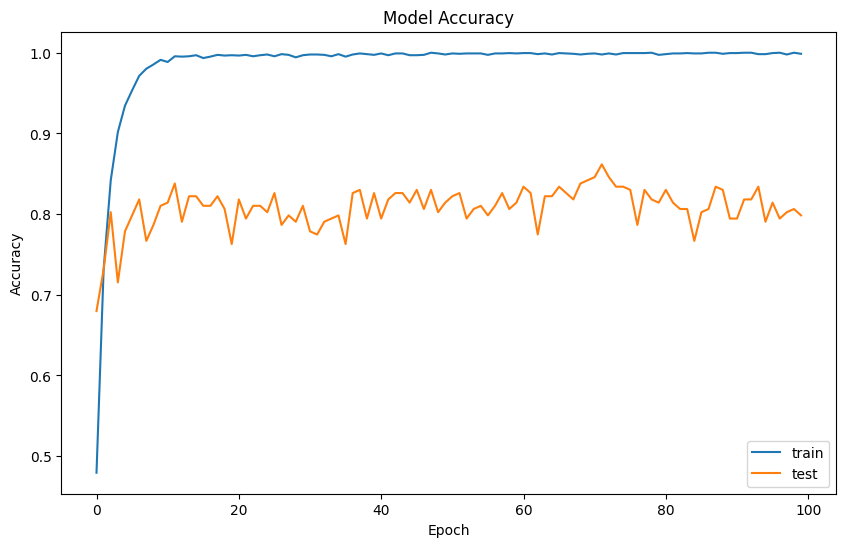

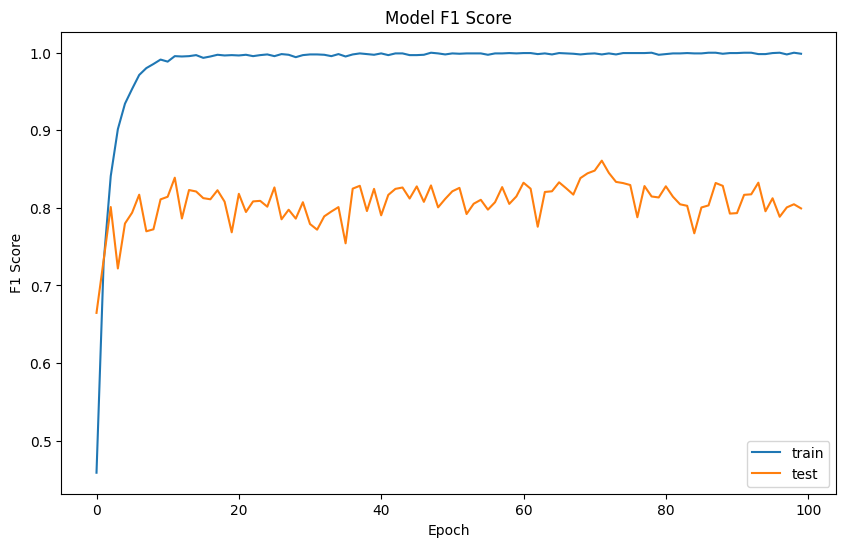

In [22]:
plot_result(log_data)